# 二次遅れ系に対するPID制御のパラメータ最適化におけるCMA-ES

In [41]:
%matplotlib inline

In [42]:
import numpy as np
from matplotlib import pyplot as plt

### 二次遅れ系のシミュレーション

二次遅れ系は一般に
$$
a_2 \ddot{y}(t) + a_1 \dot{y}(t) + a_0 y(t) = u(t)
$$
で表されるシステムであり、これをラプラス変換した伝達関数は
$$
G(s) = \frac{K\omega^2}{s^2+2\zeta\omega s+\omega^2}
$$
で表される。ここで
$$
K = \frac{1}{a_0},\quad
\zeta = \frac{a_1}{2\sqrt{a_0 a_2}},\quad
\omega = \sqrt{\frac{a_0}{a_2}},\quad
$$

ここで、
$$
y(0) = 0,\quad \dot{y}(0) = 0,\quad \ddot{y}(t) = 0
$$
と初期化し、
$$
\begin{align*}
y(t+\Delta_t) &= y(t) + \dot{y}(t)\Delta_t\\[10pt]
\dot{y}(t+\Delta_t) &= \dot{y}(t) + \ddot{y}(t)\Delta_t \\[10pt]
\ddot{y}(t+\Delta_t) &= \frac{u(t+\Delta_t) - a_0 y(t+\Delta_t) - a_1 \dot{y}(t+\Delta_t)}{a_2}
\end{align*}
$$
と更新していけば離散時間において数値的に$y(t)$が求まる。

In [52]:
# 自作モジュールのインポート

import lib.simulate
import lib.cmaes

import importlib
importlib.reload(lib.simulate)
importlib.reload(lib.cmaes)

from lib.simulate import SecondOrderSystem, PID
from lib.cmaes import CMAES


### インパルス応答

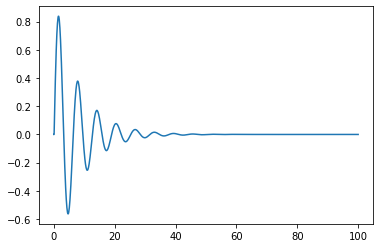

In [53]:
tf = SecondOrderSystem() # 二次遅れ系
u = np.zeros(1000)
u[0] = 10.0

for i in range(999):
    tf.response(u[i])

tf.result()   # インパルス応答

### ステップ応答

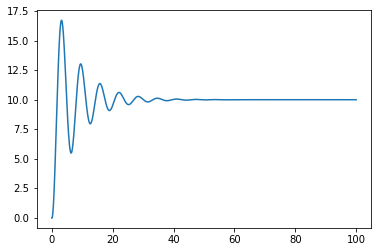

In [45]:
tf = SecondOrderSystem() # 二次遅れ系
u = 10 * np.ones(1000)

for i in range(999):
    tf.response(u[i])

tf.result()  # ステップ応答

### PID制御

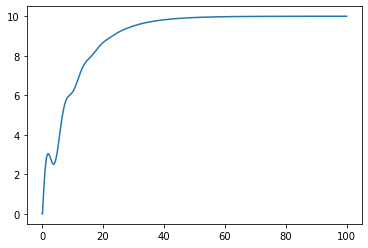

In [46]:
tf = SecondOrderSystem() # 二次遅れ系
controller = PID(0.05, 0.01, 3)  # 係数は適当
y = 0
target = 10

for i in range(999):
    u = controller.cal_next_input(target-y)
    y = tf.response(u)

tf.result()

### CMA-ESによる学習

#### 評価関数
目標値とyの出力の二乗和を評価関数とする

In [47]:
def evaluate(x):
    y = 0
    controler = PID(*x)
    tf = SecondOrderSystem(time=50)
    r = 0
    for i in range(499):
        u = controler.cal_next_input(10-y)
        y = tf.response(u)
    
    return np.sum((10-tf.y[:,0])**2)

In [50]:
es = CMAES(func=evaluate,\
            init_mean=np.array([0.0, 0.0, 0.0]),\
            init_sigma=100,\
            nsample=100)

mean = np.zeros(5000, dtype=np.float64)

for i in range(5000):
    es.sample()
    es.evaluate()
    es.update_param()
    mean[i] = es.func(es.mean)
    if np.all(es.sigma*np.sqrt(es.D) < 1e-10):
        break

print(es.mean)

/var/folders/yb/bs4kw7bj6wn2h4_8gns5w3qh0000gn/T/ipykernel_3249/1405873389.py:10: RuntimeWarning: overflow encountered in square
  return np.sum((10-tf.y[:,0])**2)


KeyboardInterrupt: 

/var/folders/yb/bs4kw7bj6wn2h4_8gns5w3qh0000gn/T/ipykernel_3249/70860131.py:13: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(np.min(mean),np.max(mean[200:]))
/var/folders/yb/bs4kw7bj6wn2h4_8gns5w3qh0000gn/T/ipykernel_3249/70860131.py:13: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(np.min(mean),np.max(mean[200:]))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


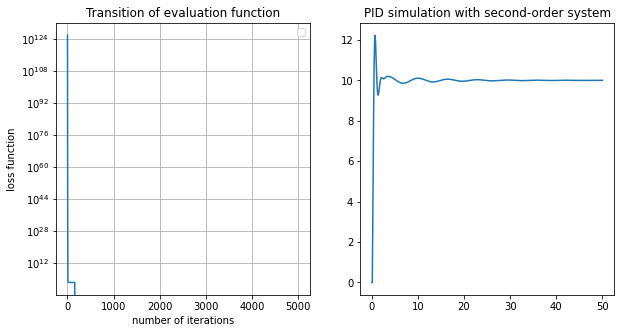

In [51]:
controler = PID(*es.mean)
tf = SecondOrderSystem(time=50)
y = 0
for i in range(499):
    u = controler.cal_next_input(10-y)
    y = tf.response(u)

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.title("Transition of evaluation function")
plt.semilogy(mean)
plt.ylim(np.min(mean),np.max(mean[200:]))
plt.xlabel("number of iterations")
plt.ylabel("loss function")
plt.grid()
plt.legend()

plt.subplot(122)
plt.title("PID simulation with second-order system")
plt.plot(np.linspace(0, 50, 500), tf.y[:,0])

#### 結果
評価関数の値は収束に向かっているが、シミュレーションは目標値$\pm 1$で振動している  

#### 考察
目標値$\pm 1$では二乗されて誤差が小さくなる一方、初期値は誤差が二乗されて大きくなる  
　　→振動を抑えることより、初期値から早く脱する方を優先して学習されている

評価関数を偏差の絶対値の和に変更する

In [24]:
def evaluate(x):
    y = 0
    controler = PID(*x)
    tf = SecondOrderSystem(dt=0.05,time=50)
    r = 0
    for i in range(999):
        u = controler.cal_next_input(10-y)
        y = tf.response(u)
    
    return np.sum(np.abs(10-tf.y[:,0]))

In [34]:
es = CMAES(func=evaluate,\
            init_mean=np.array([0.0, 0.0, 0.0]),\
            init_sigma=10,\
            nsample=100)

mean = np.zeros(500, dtype=np.float64)

for i in range(500):
    es.sample()
    es.evaluate()
    es.update_param()
    mean[i] = es.func(es.mean)
    if np.all(es.sigma*np.sqrt(es.D) < 1e-10):
        break

print(es.mean)

[ 1.1620406   0.23240812 91.56879958]


In [35]:
print(es.B)
print(es.D)
print(es.C)
print(es.sigma)
print(es.mean)

[[ 0.00999187 -0.99987307 -0.01240998]
 [-0.99994713 -0.00996093 -0.00255228]
 [ 0.00242834  0.01243482 -0.99991974]]
[2.87455257e-33 1.77441364e-30 2.98691109e-26]
[[6.37403204e-30 9.63710885e-31 3.70623188e-28]
 [9.63710885e-31 1.97621935e-31 7.62280400e-29]
 [3.70623188e-28 7.62280400e-29 2.98643165e-26]]
441.0133642380144
[ 1.1620406   0.23240812 91.56879958]


In [37]:
np.min(mean[mean>0])

42.509787824166985

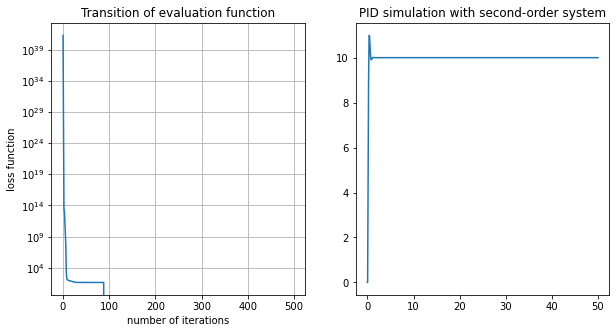

In [40]:
controler = PID(*es.mean)
tf = SecondOrderSystem(time=50,dt=0.05)
y = 0
for i in range(999):
    u = controler.cal_next_input(10-y)
    y = tf.response(u)

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.title("Transition of evaluation function")
plt.xlabel("number of iterations")
plt.ylabel("loss function")
# plt.ylim(np.min(mean),np.max(mean[500:]))
plt.plot(np.arange(mean.shape[0]),mean)
plt.yscale("log")
plt.grid()

plt.subplot(122)
plt.title("PID simulation with second-order system")
plt.plot(np.linspace(0, 50, 1000), tf.y[:,0])

#### 結果
先ほどより振動が抑えられているが、最初の段階で少しオーバーシュートしている。

#### 考察
初期値が目標から離れている分、やはりまだ初期値を脱することに重点が置かれている。

評価関数が以下の性質を満たすようにしたい  
- 偏差が大きくなっても評価関数が大きくなりすぎない
- 上に凸

→自然対数を用いる。

In [57]:
def evaluate(x):
    y = 0
    controler = PID(*x)
    tf = SecondOrderSystem(time=50)
    r = 0
    for i in range(499):
        u = controler.cal_next_input(10-y)
        y = tf.response(u)
    
    return np.sum(np.log(np.abs(10 - tf.y[:,0])+1))


In [58]:
es = CMAES(func=evaluate,\
            init_mean=np.array([0.0, 0.0, 0.0]),\
            init_sigma=10,\
            nsample=100)

mean = np.zeros(2000, dtype=np.float64)

for i in range(2000):
    es.sample()
    es.evaluate()
    es.update_param()
    mean[i] = es.func(es.mean)

print(es.mean)

[ 0.59639939  0.39759963 38.7659644 ]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


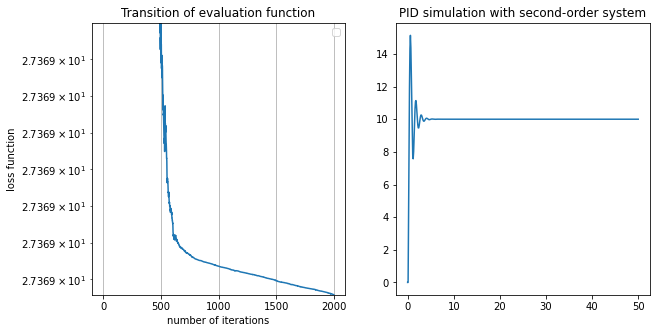

In [59]:
controler = PID(*es.mean)
tf = SecondOrderSystem(time=50)
y = 0
for i in range(499):
    u = controler.cal_next_input(10-y)
    y = tf.response(u)

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.title("Transition of evaluation function")
plt.semilogy(mean)
plt.ylim(np.min(mean),np.max(mean[500:]))
plt.xlabel("number of iterations")
plt.ylabel("loss function")
plt.grid()
plt.legend()

plt.subplot(122)
plt.title("PID simulation with second-order system")
plt.plot(np.linspace(0, 50, 500), tf.y[:,0])

#### 結果
先ほどより振動する時間が短くなっているが、最初は大きく振動している。

→振動に対するペナルティとして、$y$の二階微分の二乗の累積を評価関数に足す。

In [61]:
def evaluate(x):
    y = 0
    controler = PID(*x)
    tf = SecondOrderSystem(time=50)
    r = 0
    for i in range(499):
        u = controler.cal_next_input(10-y)
        y = tf.response(u)
    
    return np.sum(np.log(np.abs(10 - tf.y[:,0])+1)) + np.sum((tf.y[:,2]/20)**2)

In [62]:
es = CMAES(func=evaluate,\
            init_mean=np.array([0.0, 0.0, 0.0]),\
            init_sigma=10,\
            nsample=100)

mean = np.zeros(2000, dtype=np.float64)

for i in range(2000):
    es.sample()
    es.evaluate()
    es.update_param()
    mean[i] = es.func(es.mean)

print(es.mean)

[ 0.33854414  0.22569609 22.00536918]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


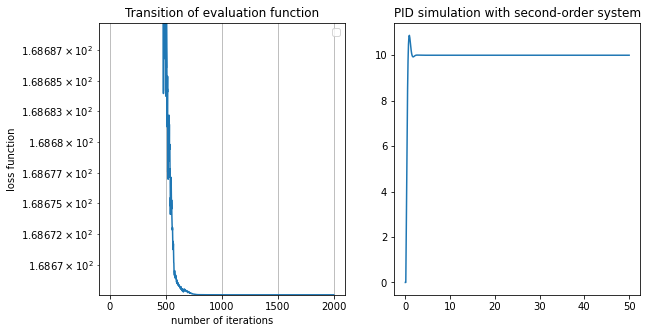

In [67]:
controler = PID(*es.mean)
tf = SecondOrderSystem(time=50)
y = 0
for i in range(499):
    u = controler.cal_next_input(10-y)
    y = tf.response(u)

plt.figure(figsize=(15,5))

plt.subplot(131)
plt.title("Transition of evaluation function")
plt.semilogy(mean)
plt.ylim(np.min(mean),np.max(mean[500:]))
plt.xlabel("number of iterations")
plt.ylabel("loss function")
plt.grid()
plt.legend()

plt.subplot(132)
plt.title("PID simulation with second-order system")
plt.plot(np.linspace(0, 50, 500), tf.y[:,0])

### 結果
概ね望んだ通りの方向に進んでいる気がするのでこのまま学習回数を増やしてみる。

In [40]:
es = CMAES(func=evaluate,\
            init_mean=np.array([0.0, 0.0, 0.0]),\
            init_sigma=10,\
            nsample=100)

mean = np.zeros(10000, dtype=np.float64)

for i in range(10000):
    es.sample()
    es.evaluate()
    es.update_param()
    mean[i] = es.func(es.mean)

print(es.mean)

[ 0.34225268  0.22816845 22.24642403]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


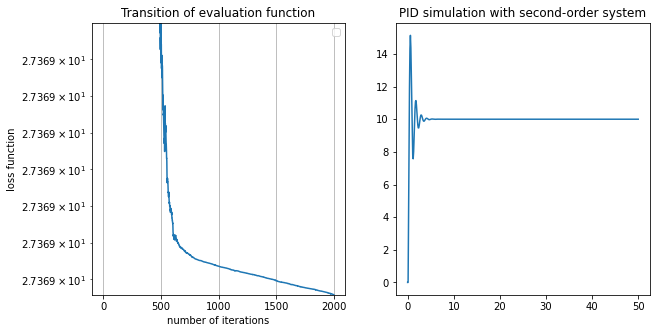

In [60]:
controler = PID(*es.mean)
tf = SecondOrderSystem(time=50)
y = 0
for i in range(499):
    u = controler.cal_next_input(10-y)
    y = tf.response(u)

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.title("Transition of evaluation function")
plt.semilogy(mean)
plt.ylim(np.min(mean),np.max(mean[500:]))
plt.xlabel("number of iterations")
plt.ylabel("loss function")
plt.grid()
plt.legend()

plt.subplot(122)
plt.title("PID simulation with second-order system")
plt.plot(np.linspace(0, 50, 500), tf.y[:,0])